<a href="https://colab.research.google.com/github/MithunSR/pytorch_tutorial/blob/main/06_pytorch_transfer_learning_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3812, done.
remote: Counting objects: 100% (455/455), done.
remote: Compressing objects: 100% (272/272), done.
remote: Total 3812 (delta 238), reused 351 (delta 176), pack-reused 3357
Receiving objects: 100% (3812/3812), 650.13 MiB | 32.60 MiB/s, done.
Resolving deltas: 100% (2194/2194), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f5f49a4d750>,
 ['pizza', 'steak', 'sushi'])

In [6]:
# Setup the model with pretrained weights and send it to the target device 
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 172MB/s]


In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [9]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [10]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1034 | train_acc: 0.3828 | test_loss: 0.8918 | test_acc: 0.5701
Epoch: 2 | train_loss: 0.9392 | train_acc: 0.6602 | test_loss: 0.8103 | test_acc: 0.7027
Epoch: 3 | train_loss: 0.7618 | train_acc: 0.8945 | test_loss: 0.6448 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7616 | train_acc: 0.6992 | test_loss: 0.5864 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6327 | train_acc: 0.8789 | test_loss: 0.6041 | test_acc: 0.9072
[INFO] Total training time: 149.948 seconds


In [11]:
len(test_dataloader)

3

In [12]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model_0.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model_0(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

In [13]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [14]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 49.0 MB/s eta 0:00:00
mlxtend version: 0.22.0


In [15]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.22.0


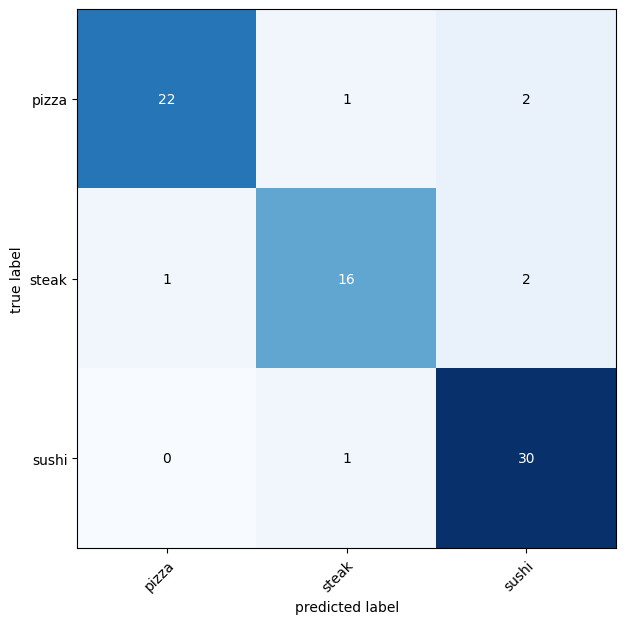

In [16]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names),task='multiclass')
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)

2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:

In [17]:
# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

       # Make sure things in the dictionary are back on the CPU 
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class
  
    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model_0,
                                 transform=simple_transform,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5213221311569214,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5732696652412415,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/3475871.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.5191609263420105,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/398345.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7014042139053345,
  'pred_class': 'pizza',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/pizza/416067.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.8299278020858765,
  'pred_class': 'pizza',
  'correct': True}]

In [18]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob 
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
73,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.509456,steak,False
11,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.454934,sushi,False
8,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.427036,steak,False
40,data/pizza_steak_sushi/test/steak/1285886.jpg,steak,0.422380,sushi,False
33,data/pizza_steak_sushi/test/steak/1627703.jpg,steak,0.389061,sushi,False


In [19]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob 
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

,image_path,class_name,pred_prob,pred_class,correct
73,data/pizza_steak_sushi/test/sushi/684266.jpg,sushi,0.509456,steak,False
11,data/pizza_steak_sushi/test/pizza/971934.jpg,pizza,0.454934,sushi,False
8,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,0.427036,steak,False
40,data/pizza_steak_sushi/test/steak/1285886.jpg,steak,0.422380,sushi,False
33,data/pizza_steak_sushi/test/steak/1627703.jpg,steak,0.389061,sushi,False


3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?

--2023-05-24 01:34:10--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 146.75.94.208, 2a04:4e42:87::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.94.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4343742 (4.1M) [image/jpeg]
Saving to: ‘photo-1588315029754-2dd089d39a1a’

photo-1588315029754 100%[===================>]   4.14M  --.-KB/s    in 0.05s   

2023-05-24 01:34:11 (81.4 MB/s) - ‘photo-1588315029754-2dd089d39a1a’ saved [4343742/4343742]



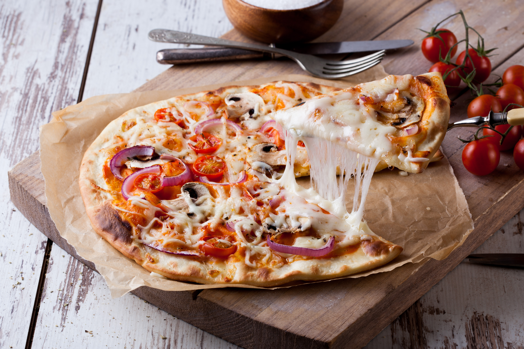

In [20]:

# Get an image of pizza/steak/sushi
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a 
!cp photo-1588315029754-2dd089d39a1a pizza.jpg

from PIL import Image

with Image.open("pizza.jpg") as img:
  # Reduce the image size and width by 10
  (width, height) = (img.width // 10, img.height // 10)
  img_resized = img.resize((width, height))

img_resized

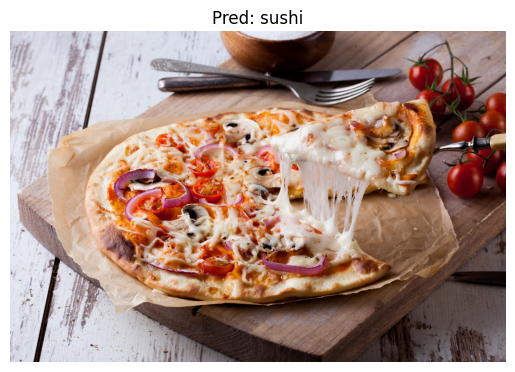

In [21]:
# Make a function to pred and plot images
def pred_and_plot(image_path, model, transform, class_names, device=device):
  # open image
  image = Image.open(image_path)

  # transform image
  transformed_image = transform(image)

  # pred on image
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)
  
  # plot image and pred
  plt.figure() 
  plt.imshow(image)
  plt.title(f"Pred: {class_names[pred_label]}")
  plt.axis(False);

pred_and_plot(image_path="pizza.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

--2023-05-24 01:34:18--  https://images.unsplash.com/photo-1546964124-0cce460f38ef
Resolving images.unsplash.com (images.unsplash.com)... 146.75.94.208, 2a04:4e42:87::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.94.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13559943 (13M) [image/jpeg]
Saving to: ‘photo-1546964124-0cce460f38ef’

photo-1546964124-0c 100%[===================>]  12.93M  --.-KB/s    in 0.1s    

2023-05-24 01:34:18 (108 MB/s) - ‘photo-1546964124-0cce460f38ef’ saved [13559943/13559943]



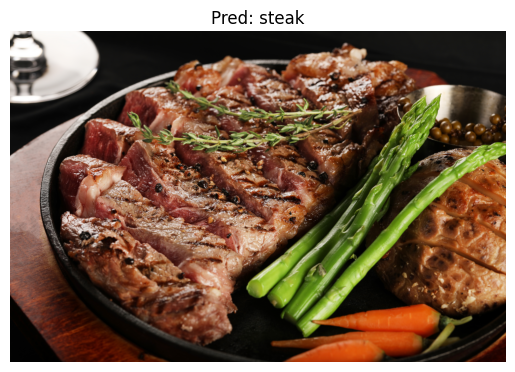

In [22]:
# Try again on a photo of steak from unsplash.com 
!wget https://images.unsplash.com/photo-1546964124-0cce460f38ef
!cp photo-1546964124-0cce460f38ef steak.jpg

pred_and_plot("steak.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)

--2023-05-24 01:34:25--  https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
Resolving images.unsplash.com (images.unsplash.com)... 146.75.94.208, 2a04:4e42:87::720
Connecting to images.unsplash.com (images.unsplash.com)|146.75.94.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6876691 (6.6M) [image/jpeg]
Saving to: ‘photo-1570913149827-d2ac84ab3f9a’

photo-1570913149827 100%[===================>]   6.56M  --.-KB/s    in 0.06s   

2023-05-24 01:34:25 (106 MB/s) - ‘photo-1570913149827-d2ac84ab3f9a’ saved [6876691/6876691]



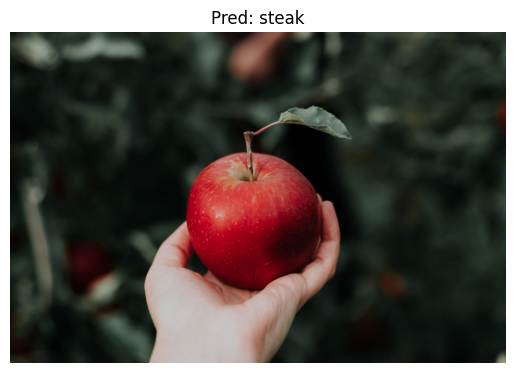

In [23]:
# Get an image of not pizza/steak/sushi
!wget https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
!cp photo-1570913149827-d2ac84ab3f9a apple.jpg 

pred_and_plot(image_path="apple.jpg",
              model=model_0,
              transform=simple_transform,
              class_names=class_names)
     

4. Train the model from section 4 above for longer (10 epochs should do), what happens to the performance?

In [24]:
# Recreate a new model 
import torchvision 
from torch import nn
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze the base layers
for param in model_1.features.parameters():
  param.requires_grad = False

# Change the classification head
torch.manual_seed(42)
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device) 

# summary(model_1, 
#         input_size=[32, 3, 224, 224],
#         col_names=["input_size", "output_size", "trainable"])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Create loss and optimizer 
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1034 | train_acc: 0.3828 | test_loss: 0.8918 | test_acc: 0.5701
Epoch: 2 | train_loss: 0.9392 | train_acc: 0.6602 | test_loss: 0.8103 | test_acc: 0.7027
Epoch: 3 | train_loss: 0.7618 | train_acc: 0.8945 | test_loss: 0.6448 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7616 | train_acc: 0.6992 | test_loss: 0.5864 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.6327 | train_acc: 0.8789 | test_loss: 0.6041 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.5923 | train_acc: 0.7969 | test_loss: 0.5559 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.5783 | train_acc: 0.8047 | test_loss: 0.5762 | test_acc: 0.8665
Epoch: 8 | train_loss: 0.5110 | train_acc: 0.7930 | test_loss: 0.4998 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4743 | train_acc: 0.9258 | test_loss: 0.5096 | test_acc: 0.8968
Epoch: 10 | train_loss: 0.5413 | train_acc: 0.8047 | test_loss: 0.5349 | test_acc: 0.9176
[INFO] Total training time: 323.343 seconds


[INFO] Couldn't find helper_functions.py, downloading...


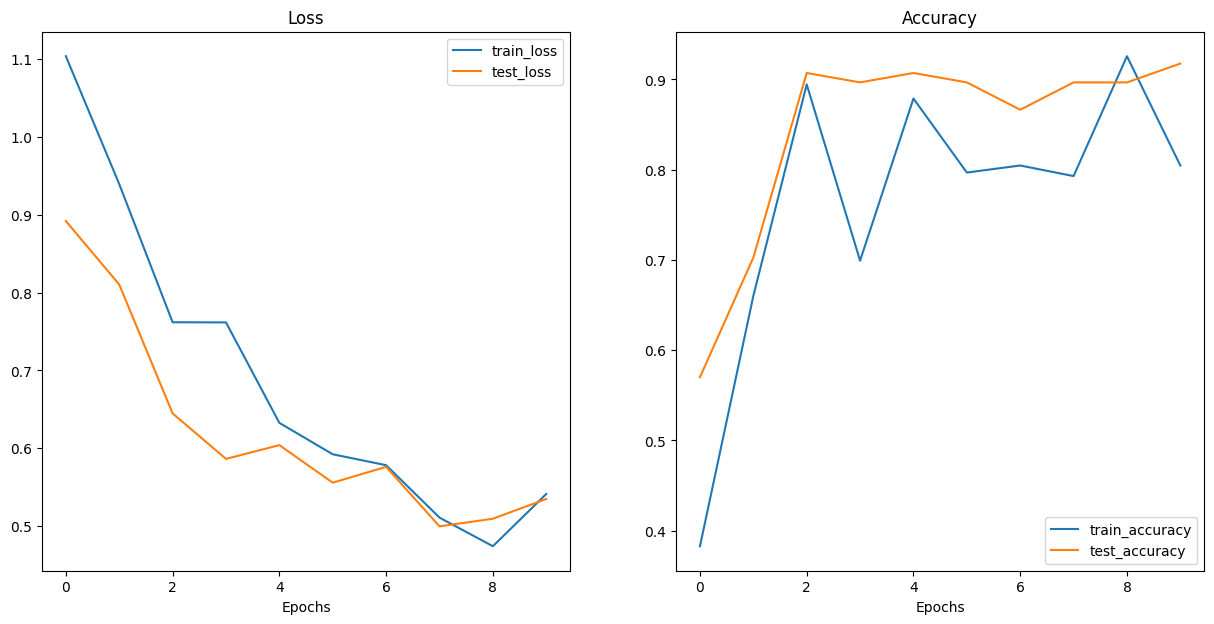

In [26]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(model_1_results)
     

5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
You can find the 20% Pizza, Steak, Sushi dataset on the course GitHub. It was cre

In [27]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...") 
        zip_ref.extractall(image_path)
        
        # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [28]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [29]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f5f25cb4ca0>,
 ['pizza', 'steak', 'sushi'])

In [30]:
len(train_dataloader_20_percent), len(test_dataloader_20_percent)

(15, 5)

In [31]:
# Create a new model for 20 percent of the data
model_2 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all the base layers
for param in model_2.features.parameters():
  param.requires_grad = False

# Change the classifier head
torch.manual_seed(42)
model_2.classifier = nn.Sequential(
  nn.Dropout(p=0.2, inplace=True),
  nn.Linear(in_features=1280, out_features=3, bias=True)
).to(device) 

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                              train_dataloader=train_dataloader_20_percent,
                              test_dataloader=test_dataloader_20_percent,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9909 | train_acc: 0.5479 | test_loss: 0.6569 | test_acc: 0.8824
Epoch: 2 | train_loss: 0.7174 | train_acc: 0.7917 | test_loss: 0.5414 | test_acc: 0.8852
Epoch: 3 | train_loss: 0.5667 | train_acc: 0.8542 | test_loss: 0.4511 | test_acc: 0.8943
Epoch: 4 | train_loss: 0.4656 | train_acc: 0.9000 | test_loss: 0.4057 | test_acc: 0.8852
Epoch: 5 | train_loss: 0.4533 | train_acc: 0.8688 | test_loss: 0.3748 | test_acc: 0.8943
[INFO] Total training time: 298.880 seconds


In [33]:

# Check results with 10% of data for 5 epochs
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.9071969696969697, 0.5864120225111643)

In [34]:
# Check results with 20% of data for 5 epochs 
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.8943181818181818, 0.3748179614543915)

6. Try a different model from torchvision.models on the Pizza, Steak, Sushi data, how does this model perform?

In [35]:
# Create a transform to transform the data
from torchvision import transforms, models
effnet_b2_transform = transforms.Compose([
  transforms.Resize((288, 288)), # effnet_b2 takes images of size 288, 288 - https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [36]:
# Use 10% data sample for effnet_b2 to compare to model_0_results
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [37]:
# Import the data
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                   test_dir=test_dir,
                                                                                                   transform=effnet_b2_transform,
                                                                                                   batch_size=32)

In [38]:
# Create a effnet_b2 new model - https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2
model_3 = torchvision.models.efficientnet_b2(pretrained=True).to(device)

# Freeze the base layers
for param in model_3.parameters():
  param.requires_grad = False

# Change the classifier head (to suit our problem)
torch.manual_seed(42)
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
).to(device)

# Get a summary of the new model
# summary(model_3,
#         input_size=[32, 3, 288, 288],
#         col_names=["input_size", "output_size", "trainable"])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 81.0MB/s]


In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
model_3_results = engine.train(model=model_3,
                              train_dataloader=train_dataloader_effnet_b2,
                              test_dataloader=test_dataloader_effnet_b2,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1042 | train_acc: 0.3477 | test_loss: 0.9398 | test_acc: 0.6203
Epoch: 2 | train_loss: 0.9087 | train_acc: 0.5781 | test_loss: 0.8734 | test_acc: 0.7642
Epoch: 3 | train_loss: 0.7394 | train_acc: 0.8633 | test_loss: 0.7615 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.7970 | train_acc: 0.7227 | test_loss: 0.7243 | test_acc: 0.7955
Epoch: 5 | train_loss: 0.6818 | train_acc: 0.7695 | test_loss: 0.6740 | test_acc: 0.9280
[INFO] Total training time: 401.230 seconds


In [40]:
# Check effnet_b0 results with 10% of data for 5 epochs
max(model_0_results["test_acc"]), min(model_0_results["test_loss"])

(0.9071969696969697, 0.5864120225111643)

In [41]:
# Check effnet_b0 results with 10% of data for 10 epochs (double training time)
max(model_1_results["test_acc"]), min(model_1_results["test_loss"])

(0.9176136363636364, 0.4998188813527425)

In [42]:
# Check effnet_b0 results with 20% of data for 5 epochs (double data)
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.8943181818181818, 0.3748179614543915)

In [43]:
# Check effnet_b2 results with 10% of data for 5 epochs (double model parameters)
max(model_3_results["test_acc"]), min(model_3_results["test_loss"])

(0.9280303030303031, 0.6739830374717712)